Our first task is to get some data that we think is useful.  For now, I'll make some intuitive guesses about how the data should be presented.  There are a number of things I'll do as a first pass:

* Normalize categorical data to simpler versions
* Use "one-hot" vector representations for categorical data
* Remove less-interesting columns

In [2]:
import pandas as pd

In [3]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
         'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
         'hours_per_week', 'native_country', 'income']
incomes = pd.read_csv('adult.data', names=names)
incomes.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


There's a lot of categorical data there, some of which doesn't make a lot of sense to me.  Even reading the meta data about the project doesn't tell me enough about it.

In [4]:
incomes.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,189778.366512,10.080679,1077.648844,87.303830,40.437456
std,13.640433,105549.977697,2.572720,7385.292085,402.960219,12.347429
min,17.000000,12285.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,117827.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,178356.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,237051.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,1484705.000000,16.000000,99999.000000,4356.000000,99.000000


In [5]:
incomes.shape

(32561, 15)

Since age is numeric, let's just plot it to see if there are any surprises.

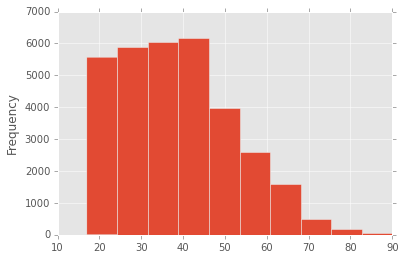

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
incomes['age'].plot(kind='hist')

It looks like the early years are cut off. Respondents were all 16 years old or older.

Let's take a look at the education years.

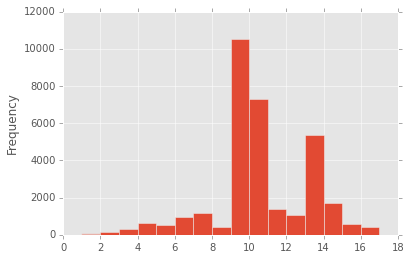

In [7]:
years = incomes['education_num']
binwidth = 1
years.plot(kind='hist', bins=range(min(years), max(years) + binwidth + 1, binwidth))

In [8]:
years.describe()

count    32561.000000
mean        10.080679
std          2.572720
min          1.000000
25%          9.000000
50%         10.000000
75%         12.000000
max         16.000000
Name: education_num, dtype: float64

count    32561.000000
mean      1957.418353
std         13.640433
min       1906.000000
25%       1948.000000
50%       1959.000000
75%       1968.000000
max       1979.000000
Name: age, dtype: float64

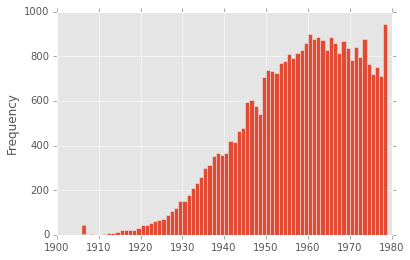

In [9]:
birth_years = incomes['age'].map(lambda x: 1996 - x)
birth_years.plot(kind='hist', bins=range(min(birth_years), max(birth_years) + binwidth, binwidth))
birth_years.describe()

So, most people get into high school and many complete their Bachelor's Degree.  I had to take a harder look at that, because I didn't believe so few finished high school.  Apparently a lot of the people polled had not in 1996.

Now, let's see how many hours a week people work.

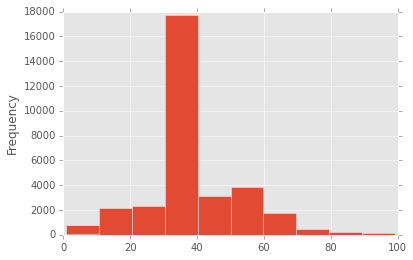

In [10]:
incomes['hours_per_week'].plot(kind='hist')

Looks like almost everyone works a 40-hour work week.

Next, I'd like to start addressing some of the categorical data.  I'll just take them on one at a time.

In [11]:
print incomes['workclass'].describe()
print incomes['workclass'].unique()

count        32561
unique           9
top        Private
freq         22696
Name: workclass, dtype: object
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']


It looks like I have a few problems here:

* The categories have white space padding which is annoying but I'll just cleanup while I clean other issues
* There are some unknown work class values, represented with a ' ?' instead of just missing.  Pandas fillna won't work here, but we're converting the whole column, so we'll just treat it as a value.
* A lot of the distinctions **might** be interesting, but not interesting enough for me today, so I'll group things up into fewer categories

To clean this colum up, I'm going to use Pandas' replace method with a dictionary mapping values to a normalized, smaller set.

In [12]:
workclass_dict = {' State-gov': 'government', ' Self-emp-not-inc': 'self',
       ' Private': 'private', ' Federal-gov': 'government',
       ' Local-gov': 'government', ' ?': 'unknown',
       ' Self-emp-inc': 'self', ' Without-pay': 'unemployed',
       ' Never-worked': 'unemployed'}

incomes.replace({'workclass': workclass_dict}, inplace=True)
print incomes['workclass'].describe()
print incomes['workclass'].unique()

count       32561
unique          5
top       private
freq        22696
Name: workclass, dtype: object
['government' 'self' 'private' 'unknown' 'unemployed']


What we see is we went from 9 values down to 5.  Self-employed and privately employed might not be enough of a distinction, so we might decide to come back and normalize this further.

Another column we can examine is education.

In [13]:
print incomes['education'].describe()
print incomes['education'].unique()

count        32561
unique          16
top        HS-grad
freq         10501
Name: education, dtype: object
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']


Here, we see there are 16 types of education, but probably a lot of those distinctions don't matter as much.  That is, many job offerings don't make these distinctions, so we won't either.

In [14]:
education_dict = {' Bachelors': 'bachelors', ' HS-grad': 'highschool', ' 11th': 'non_grad',
       ' Masters': 'professional', ' 9th': 'nongrad', ' Some-college': 'some_college',
       ' Assoc-acdm': 'some_college', ' Assoc-voc': 'some_college', ' 7th-8th': 'non_grad',
       ' Doctorate': 'doctorate', ' Prof-school': 'professional', ' 5th-6th': 'non_grad',
       ' 10th': 'non_grad', ' 1st-4th': 'non_grad', ' Preschool': 'non_grad',
       ' 12th': 'non_grad'}
incomes.replace({'education': education_dict}, inplace=True)
print incomes['education'].describe()
print incomes['education'].unique()

count          32561
unique             7
top       highschool
freq           10501
Name: education, dtype: object
['bachelors' 'highschool' 'non_grad' 'professional' 'nongrad'
 'some_college' 'doctorate']


What we see is we went from 16 categories to 7.  We may be able to reduce that to 3 or 4 if the distinctions aren't very interesting.  We also have an education_num column which is the number of years the respondent spent in school.  The decision trees, might find cutoffs that are more useful and we can either drop this column or choose to match the more-interesting cutoffs.

Marital status is also a bit confusing.  Let's simplify that to married or not.

In [15]:
print incomes['marital_status'].describe()
print incomes['marital_status'].unique()

count                   32561
unique                      7
top        Married-civ-spouse
freq                    14976
Name: marital_status, dtype: object
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']


In [16]:
marital_dict = {' Never-married': 0, ' Married-civ-spouse': 1,
       ' Divorced': 0, ' Married-spouse-absent': 1,
       ' Separated': 0, ' Married-AF-spouse': 1,
       ' Widowed': 0}
incomes['is_married'] = incomes.apply(lambda row: marital_dict[row['marital_status']], axis=1)
incomes = incomes.drop('marital_status', axis=1)
incomes.head()

,age,workclass,fnlwgt,education,education_num,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,is_married
0,39,government,77516,bachelors,13,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,self,83311,bachelors,13,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,1
2,38,private,215646,highschool,9,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,private,234721,non_grad,7,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,1
4,28,private,338409,bachelors,13,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,1


Sex (gender) is a boolean value in our dataset.  We'll reduce that to 0 for Male and 1 for Female.

In [17]:
print incomes['sex'].describe()
print incomes['sex'].unique()
incomes['sex'][incomes['sex'] == ' Male'] = 0
incomes['sex'][incomes['sex'] == ' Female'] = 1
incomes.head()

count     32561
unique        2
top        Male
freq      21790
Name: sex, dtype: object
[' Male' ' Female']


/usr/local/codez/spikes/p27/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/codez/spikes/p27/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,age,workclass,fnlwgt,education,education_num,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,is_married
0,39,government,77516,bachelors,13,Adm-clerical,Not-in-family,White,0,2174,0,40,United-States,<=50K,0
1,50,self,83311,bachelors,13,Exec-managerial,Husband,White,0,0,0,13,United-States,<=50K,1
2,38,private,215646,highschool,9,Handlers-cleaners,Not-in-family,White,0,0,0,40,United-States,<=50K,0
3,53,private,234721,non_grad,7,Handlers-cleaners,Husband,Black,0,0,0,40,United-States,<=50K,1
4,28,private,338409,bachelors,13,Prof-specialty,Wife,Black,1,0,0,40,Cuba,<=50K,1


The occupation data seems a little specific to me.

In [18]:
print incomes['occupation'].describe()
print incomes['occupation'].unique()

count               32561
unique                 15
top        Prof-specialty
freq                 4140
Name: occupation, dtype: object
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']


There are 15 types of occupations, many of which seem too specific.

In [19]:
occupation_dict = {' Adm-clerical': 'clerical', ' Exec-managerial': 'professional', 
                   ' Handlers-cleaners': 'blue_collar', ' Prof-specialty': 'professional',
                   ' Other-service': 'blue_collar', ' Sales': 'sales',
                   ' Craft-repair': 'blue_collar', ' Transport-moving': 'blue_collar',
                   ' Farming-fishing': 'blue_collar', ' Machine-op-inspct': 'blue_collar',
                   ' Tech-support': 'clerical', ' ?': 'unknown', 
                   ' Protective-serv': 'protective', ' Armed-Forces': 'protective',
                   ' Priv-house-serv': 'blue_collar'}
incomes.replace({'occupation': occupation_dict}, inplace=True)
print incomes['occupation'].describe()
print incomes['occupation'].unique()

count           32561
unique              6
top       blue_collar
freq            13506
Name: occupation, dtype: object
['clerical' 'professional' 'blue_collar' 'sales' 'unknown' 'protective']


In [20]:
incomes.head()

,age,workclass,fnlwgt,education,education_num,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,is_married
0,39,government,77516,bachelors,13,clerical,Not-in-family,White,0,2174,0,40,United-States,<=50K,0
1,50,self,83311,bachelors,13,professional,Husband,White,0,0,0,13,United-States,<=50K,1
2,38,private,215646,highschool,9,blue_collar,Not-in-family,White,0,0,0,40,United-States,<=50K,0
3,53,private,234721,non_grad,7,blue_collar,Husband,Black,0,0,0,40,United-States,<=50K,1
4,28,private,338409,bachelors,13,professional,Wife,Black,1,0,0,40,Cuba,<=50K,1


In [21]:
print incomes['race'].describe()
print incomes['race'].unique()

count      32561
unique         5
top        White
freq       27816
Name: race, dtype: object
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']


With race, I'll keep it as it is, but with more-normal names.

In [22]:
race_dict = {' White': 'white', ' Black': 'black', ' Asian-Pac-Islander': 'asian_pacific_islander',
             ' Amer-Indian-Eskimo': 'american_indian_eskimo', ' Other': 'other'}
incomes.replace({'race': race_dict}, inplace=True)
print incomes['race'].describe()
print incomes['race'].unique()

count     32561
unique        5
top       white
freq      27816
Name: race, dtype: object
['white' 'black' 'asian_pacific_islander' 'american_indian_eskimo' 'other']


In [23]:
print incomes['native_country'].describe()
print incomes['native_country'].unique()

count              32561
unique                42
top        United-States
freq               29170
Name: native_country, dtype: object
[' United-States' ' Cuba' ' Jamaica' ' India' ' ?' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' ' Iran'
 ' Philippines' ' Italy' ' Poland' ' Columbia' ' Cambodia' ' Thailand'
 ' Ecuador' ' Laos' ' Taiwan' ' Haiti' ' Portugal' ' Dominican-Republic'
 ' El-Salvador' ' France' ' Guatemala' ' China' ' Japan' ' Yugoslavia'
 ' Peru' ' Outlying-US(Guam-USVI-etc)' ' Scotland' ' Trinadad&Tobago'
 ' Greece' ' Nicaragua' ' Vietnam' ' Hong' ' Ireland' ' Hungary'
 ' Holand-Netherlands']


For countries, I think there are a few interesting things:

* Were they born here in the US?
* Were they from Central America?
* Were they from a developed country?

I'll use the [UN's Human Development Report for 1998](https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index_(1998)) for the development category.

In [24]:
def get_is_native_born(row):
    if not pd.isnull(row['native_country']):
        return 1 if row['native_country'] == ' United-States' else 0
    else:
        0
incomes['is_native_born'] = incomes.apply(lambda row: get_is_native_born(row), axis=1)

central_america_dict = {' United-States': 0, ' Cuba': 0, ' Jamaica': 0, ' India': 0, ' ?': 0, ' Mexico': 1, ' South': 1,
 ' Puerto-Rico': 0, ' Honduras': 1, ' England': 0, ' Canada': 0, ' Germany': 0, ' Iran': 0,
 ' Philippines': 0, ' Italy': 0, ' Poland': 0, ' Columbia': 0, ' Cambodia': 0, ' Thailand': 0,
 ' Ecuador': 1, ' Laos': 0, ' Taiwan': 0, ' Haiti': 0, ' Portugal': 0, ' Dominican-Republic': 0,
 ' El-Salvador': 1, ' France': 0, ' Guatemala': 1, ' China': 0, ' Japan': 0, ' Yugoslavia': 0,
 ' Peru': 0, ' Outlying-US(Guam-USVI-etc)': 0, ' Scotland': 0, ' Trinadad&Tobago': 0,
 ' Greece': 0, ' Nicaragua': 0, ' Vietnam': 0, ' Hong': 0, ' Ireland': 0, ' Hungary': 0,
 ' Holand-Netherlands': 0}

incomes['from_central_america'] = incomes.apply(lambda row: central_america_dict[row['native_country']], axis=1)

human_development_dict = {' United-States': .893, ' Cuba': .729, ' Jamaica': .735, ' India': .507,
                          ' ?': 0, ' Mexico': .75, ' South': 0, ' Puerto-Rico': .942, ' Honduras': .573,
                          ' England': .935, ' Canada': .973, ' Germany': .932, ' Iran': .758, 
                          ' Philippines': .677, ' Italy': .922, ' Poland': .895, ' Columbia': .850,
                          ' Cambodia': .422, ' Thailand': .838, ' Ecuador': .767, ' Laos': .465,
                          ' Taiwan': .868, ' Haiti': .34, ' Portugal': .795, ' Dominican-Republic': .72,
                          ' El-Salvador': .604, ' France': .872, ' Guatemala': .615, ' China': .778,
                          ' Japan': .884, ' Yugoslavia': .796, ' Peru': .729, ' Outlying-US(Guam-USVI-etc)': .893,
                          ' Scotland': .935, ' Trinadad&Tobago': .88, ' Greece': .855, ' Nicaragua': .565,
                          ' Vietnam': .56, ' Hong': .862, ' Ireland': .895, ' Hungary': .805,
                          ' Holand-Netherlands': .962}
incomes['human_development'] = incomes.apply(lambda row: human_development_dict[row['native_country']], axis=1)

unknown_countries = [' ?', ' South']
median = incomes[~incomes.native_country.isin(unknown_countries)]['human_development'].median()
incomes['human_development'][incomes.native_country.isin(unknown_countries)] = median
incomes = incomes.drop('native_country', axis=1)
incomes.head()

/usr/local/codez/spikes/p27/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,age,workclass,fnlwgt,education,education_num,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income,is_married,is_native_born,from_central_america,human_development
0,39,government,77516,bachelors,13,clerical,Not-in-family,white,0,2174,0,40,<=50K,0,1,0,0.893
1,50,self,83311,bachelors,13,professional,Husband,white,0,0,0,13,<=50K,1,1,0,0.893
2,38,private,215646,highschool,9,blue_collar,Not-in-family,white,0,0,0,40,<=50K,0,1,0,0.893
3,53,private,234721,non_grad,7,blue_collar,Husband,black,0,0,0,40,<=50K,1,1,0,0.893
4,28,private,338409,bachelors,13,professional,Wife,black,1,0,0,40,<=50K,1,0,0,0.729


In [25]:
print incomes['income'].describe()
print incomes['income'].unique()

count      32561
unique         2
top        <=50K
freq       24720
Name: income, dtype: object
[' <=50K' ' >50K']


In [26]:
income_dict = {' <=50K': 0, ' >50K': 1}
incomes.replace({'income': income_dict}, inplace=True)
print incomes['income'].describe()
print incomes['income'].unique()

count    32561.000000
mean         0.240810
std          0.427581
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: income, dtype: float64
[0 1]


Now, let's drop the columns I have less confidence in (right now).

In [27]:
incomes = incomes.drop(['relationship', 'capital_gain', 'capital_loss', 'fnlwgt'], axis=1)
incomes.head()

,age,workclass,education,education_num,occupation,race,sex,hours_per_week,income,is_married,is_native_born,from_central_america,human_development
0,39,government,bachelors,13,clerical,white,0,40,0,0,1,0,0.893
1,50,self,bachelors,13,professional,white,0,13,0,1,1,0,0.893
2,38,private,highschool,9,blue_collar,white,0,40,0,0,1,0,0.893
3,53,private,non_grad,7,blue_collar,black,0,40,0,1,1,0,0.893
4,28,private,bachelors,13,professional,black,1,40,0,1,0,0,0.729


Finally, let's create the "one-hot" vector columns.

In [28]:
incomes = pd.get_dummies(incomes, columns=['workclass', 'education', 'occupation', 'race'])
incomes.head()

,age,education_num,sex,hours_per_week,income,is_married,is_native_born,from_central_america,human_development,workclass_government,...,occupation_clerical,occupation_professional,occupation_protective,occupation_sales,occupation_unknown,race_american_indian_eskimo,race_asian_pacific_islander,race_black,race_other,race_white
0,39,13,0,40,0,0,1,0,0.893,1,...,1,0,0,0,0,0,0,0,0,1
1,50,13,0,13,0,1,1,0,0.893,0,...,0,1,0,0,0,0,0,0,0,1
2,38,9,0,40,0,0,1,0,0.893,0,...,0,0,0,0,0,0,0,0,0,1
3,53,7,0,40,0,1,1,0,0.893,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13,1,40,0,1,0,0,0.729,0,...,0,1,0,0,0,0,0,1,0,0


Now, let's see how we did, generally.

In [29]:
data = incomes.drop('income', axis=1)
target = incomes['income']

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(max_depth=5, criterion="entropy")
clf.fit(data, target)
dot_file = tree.export_graphviz(clf.tree_, out_file="tree.dot", feature_names=data.columns)

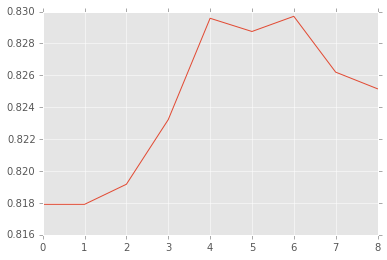

In [30]:
from sklearn.cross_validation import cross_val_score
results = []
for n in range(2, 11):
    clf = DecisionTreeClassifier(max_depth=n, min_samples_split=1)
    clf.fit(data, target)
    scores = cross_val_score(clf, data, target)
    results.append(scores.mean())
plt.plot(results)

In [31]:
data.shape

(32561, 31)

In [32]:
def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {"
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print "} else {"
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print "}"
                else:
                        print "return " + str(value[node])

        recurse(left, right, threshold, features, 0)
        
get_code(clf, data.columns)

if ( is_married <= 0.5 ) {
if ( education_num <= 13.5 ) {
if ( hours_per_week <= 42.5 ) {
if ( occupation_professional <= 0.5 ) {
if ( age <= 28.5 ) {
if ( occupation_protective <= 0.5 ) {
if ( education_num <= 10.5 ) {
if ( race_american_indian_eskimo <= 0.5 ) {
if ( human_development <= 0.646000027657 ) {
if ( workclass_government <= 0.5 ) {
return [[ 98.   1.]]
} else {
return [[ 5.  1.]]
}
} else {
if ( age <= 27.5 ) {
return [[  4.32400000e+03   2.00000000e+00]]
} else {
return [[ 219.    1.]]
}
}
} else {
if ( age <= 26.5 ) {
return [[ 38.   0.]]
} else {
if ( workclass_government <= 0.5 ) {
return [[ 6.  1.]]
} else {
return [[ 0.  1.]]
}
}
}
} else {
if ( sex <= 0.5 ) {
if ( age <= 27.5 ) {
if ( workclass_self <= 0.5 ) {
return [[ 287.    5.]]
} else {
return [[ 10.   1.]]
}
} else {
if ( hours_per_week <= 37.5 ) {
return [[ 11.   0.]]
} else {
return [[ 16.   2.]]
}
}
} else {
if ( age <= 25.5 ) {
return [[ 256.    0.]]
} else {
if ( age <= 26.5 ) {
return [[ 39.   1.]]
} else

In [33]:
import random

def get_sample(x, n=1):
    return x.ix[random.sample(x.index, n)]

def predict_sample(x, clf, n=1):
    my_sample = get_sample(x, n)
    prediction = clf.predict(my_sample)
    return prediction

predict_sample(data, clf)

array([0])

Just for kicks, I wanted to think about data normalization.  The following shows that because of the way the decision tree is built, this algorithm does not need normalization.

In [34]:
normed_data = (data - data.mean()) / (data.max() - data.min())
normed_data.head()

,age,education_num,sex,hours_per_week,is_married,is_native_born,from_central_america,human_development,workclass_government,workclass_private,...,occupation_clerical,occupation_professional,occupation_protective,occupation_sales,occupation_unknown,race_american_indian_eskimo,race_asian_pacific_islander,race_black,race_other,race_white
0,0.005731,0.194621,-0.330795,-0.004464,-0.473481,0.104143,-0.028685,0.017025,0.866374,-0.69703,...,0.855717,-0.252019,-0.020208,-0.112097,-0.056601,-0.009551,-0.031909,-0.095943,-0.008323,0.145726
1,0.156416,0.194621,-0.330795,-0.279974,0.526519,0.104143,-0.028685,0.017025,-0.133626,-0.69703,...,-0.144283,0.747981,-0.020208,-0.112097,-0.056601,-0.009551,-0.031909,-0.095943,-0.008323,0.145726
2,-0.007968,-0.072045,-0.330795,-0.004464,-0.473481,0.104143,-0.028685,0.017025,-0.133626,0.30297,...,-0.144283,-0.252019,-0.020208,-0.112097,-0.056601,-0.009551,-0.031909,-0.095943,-0.008323,0.145726
3,0.197512,-0.205379,-0.330795,-0.004464,0.526519,0.104143,-0.028685,0.017025,-0.133626,0.30297,...,-0.144283,-0.252019,-0.020208,-0.112097,-0.056601,-0.009551,-0.031909,0.904057,-0.008323,-0.854274
4,-0.144954,0.194621,0.669205,-0.004464,0.526519,-0.895857,-0.028685,-0.242059,-0.133626,0.30297,...,-0.144283,0.747981,-0.020208,-0.112097,-0.056601,-0.009551,-0.031909,0.904057,-0.008323,-0.854274


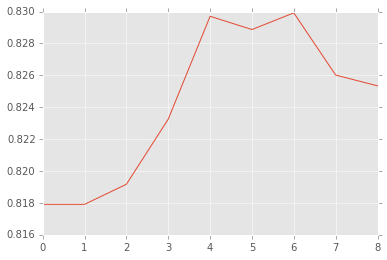

In [35]:
results = []
for n in range(2, 11):
    clf = DecisionTreeClassifier(max_depth=n, min_samples_split=1)
    clf.fit(normed_data, target)
    scores = cross_val_score(clf, normed_data, target)
    results.append(scores.mean())
plt.plot(results)

In [36]:
incomes = pd.read_csv('adult.data', names=names)
one_hot_names = ['sex', 'workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
incomes = pd.get_dummies(incomes, columns=one_hot_names)
incomes.shape

(32561, 111)

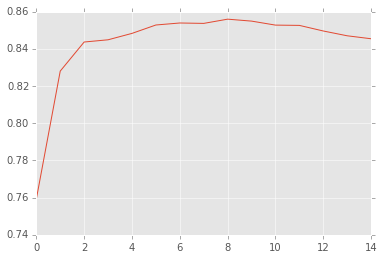

In [37]:
data = incomes.drop(['income', 'fnlwgt'], axis=1)
target = incomes['income']
results = []
for n in range(1, 16):
    clf = DecisionTreeClassifier(max_depth=n, min_samples_split=1)
    clf.fit(data, target)
    scores = cross_val_score(clf, data, target)
    results.append(scores.mean())
plt.plot(results)

In [38]:
clf = DecisionTreeClassifier(max_depth=7, min_samples_split=1)
clf.fit(data, target)
predict_sample(data, clf)

array([' <=50K'], dtype=object)

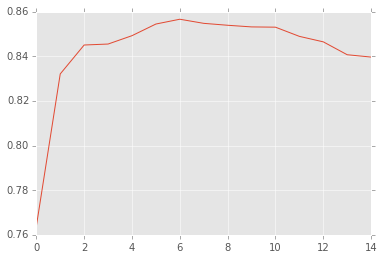

In [41]:
incomes = pd.read_csv('adult.test', names=names)
one_hot_names = ['sex', 'workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
incomes = pd.get_dummies(incomes, columns=one_hot_names)
data = incomes.drop(['income', 'fnlwgt'], axis=1)
target = incomes['income']
results = []
for n in range(1, 16):
    clf = DecisionTreeClassifier(max_depth=n, min_samples_split=1)
    clf.fit(data, target)
    scores = cross_val_score(clf, data, target)
    results.append(scores.mean())
plt.plot(results)